In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Creating training examples based on block size. 

In [4]:
block_size = 3
X,Y = [], []
for w in words:
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

Below we start constructing layers of the network. This is based on the paper titled "A Neural Probabilistic Language Model"  https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf. The network architecture is shown below. It starts off with embedding matrix C followed by tanh layer followed by softmax layer.

![NN architecture](Bengio_et_al_NN_arch.png)

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [6]:
C = torch.randn((27,2))

In [7]:
C.dtype, X.dtype

(torch.float32, torch.int64)

In [8]:
C[X].shape

torch.Size([228146, 3, 2])

In [9]:
C[5], C[[5,6,7]], C[5,1]

(tensor([-1.1094,  0.6433]),
 tensor([[-1.1094,  0.6433],
         [-1.6151, -0.9291],
         [-0.1728, -1.8884]]),
 tensor(0.6433))

In [10]:
X[13,2], C[X][13,2]

(tensor(1), tensor([-1.3296, -0.0269]))

In [11]:
C[1]

tensor([-1.3296, -0.0269])

In [12]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [13]:
W1 = torch.randn((6,100))
b1 = torch.randn((100))

In [14]:
W1.shape, b1.shape, emb.shape

(torch.Size([6, 100]), torch.Size([100]), torch.Size([228146, 3, 2]))

We want to do emb@W1, before that we need to change emb's shape for the dot product to work. 
There are many ways to do this in Pytorch, but an efficient way is to use the view() function since pytorch internally does not create any extra memory or storage for this. instead it manipulates the attributes of a tensor to show different shape.

In [ ]:
torch.cat((emb[:, 0,:], emb[:,1,:], emb[:,2,:]),1)

In [15]:
# -1 tells pytorch to infer the shape
h = torch.tanh((emb.view((-1,6))@W1+b1))
h.shape

torch.Size([228146, 100])

In [16]:
W2 = torch.randn((100,27))
b2 = torch.randn((27))
logits = h@W2 + b2
log_counts = logits.exp()
probs = log_counts/log_counts.sum(1, keepdims = True)
loss = -probs[torch.arange(len(X)), Y].log().mean()
loss

tensor(15.2983)

Lets write everything together and clean things up

In [17]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [18]:
g = torch.Generator().manual_seed(214)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6, 100), generator = g) # 6 comes since we have 3 chars as input to the neural net and an 
                                          # embedding layer of size 2
b1 = torch.randn((100), generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn((27), generator = g)
parameters = [C, W1, b1, W2, b2]

In [19]:
sum(p.nelement() for p in parameters)
for p in parameters:
    p.requires_grad = True

In [20]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [21]:
lossi = []
for i in range(1000):
    # create mini batch
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view((-1,6))@W1 + b1)
    logits = h@W2+b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr*p.grad
    # track stats
    lossi.append(loss.item())
        

15.385693550109863
15.761914253234863
13.888176918029785
15.997437477111816
15.930667877197266
14.436906814575195
16.157119750976562
11.717779159545898
15.884493827819824
15.928959846496582
14.457386016845703
14.76158332824707
15.928382873535156
15.810401916503906
14.672986030578613
13.84422779083252
15.868367195129395
17.17759895324707
16.165218353271484
14.333427429199219
14.667587280273438
16.107646942138672
12.849905967712402
12.977639198303223
11.3400239944458
13.418671607971191
16.112674713134766
15.463210105895996
13.69196605682373
12.99660587310791
17.400476455688477
15.654688835144043
13.039236068725586
14.728470802307129
14.12155532836914
14.30209732055664
15.456169128417969
14.651823997497559
13.173188209533691
14.573295593261719
13.667035102844238
15.408761024475098
12.43543529510498
13.744333267211914
15.314138412475586
14.38382339477539
13.299246788024902
14.317702293395996
15.393308639526367
15.384451866149902
13.685953140258789
14.48058032989502
12.054570198059082
15.16

To find a good learning rate, we are exploring each minibatch with a different learning rate searching through an exponential space. We plot the loss vs learning rate and try to see how the loss changes with changes in learning rate. We can see lr ~0.1 is a good sweet spot before the loss starts exploding.

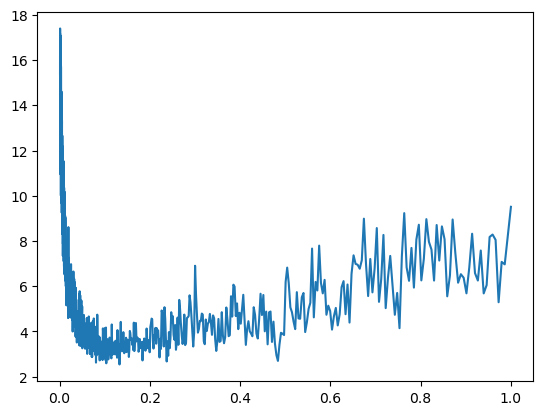

In [22]:
plt.plot(lrs, lossi)

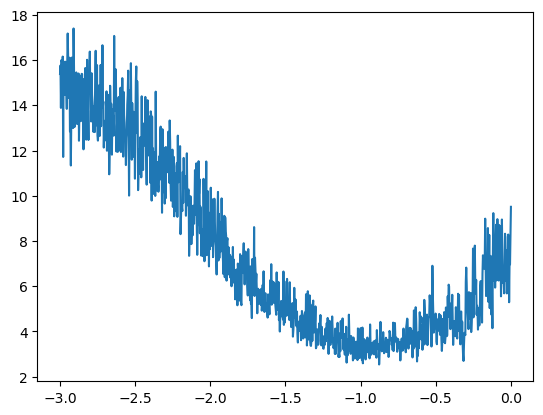

In [23]:
plt.plot(lre, lossi)

Lets rerun the training loop with a lr of 0.1. We will reinitialize the parameters of the NN before (just copying code from above to maintain flow in the notebook).

In [24]:
g = torch.Generator().manual_seed(214)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6, 100), generator = g) # 6 comes since we have 3 chars as input to the neural net and an 
                                          # embedding layer of size 2
b1 = torch.randn((100), generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn((27), generator = g)
parameters = [C, W1, b1, W2, b2]

In [25]:
for p in parameters:
    p.requires_grad = True

In [ ]:
for i in range(10000):
    # create mini batch
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view((-1,6))@W1 + b1)
    logits = h@W2+b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1*p.grad
        # do learning rate decay after few iterations and loss plateus as we get to the end of training.
        p.data += -0.01*p.grad

In [ ]:
emb = C[X]
h = torch.tanh(emb.view((-1,6))@W1 + b1)
logits = h@W2+b2
loss = F.cross_entropy(logits, Y)
loss

In [26]:
# training, dev/validation, test
# 80%, 10%, 10%
# Lets rebuild the dataset
def build_dataset(words):
    block_size = 3
    X,Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [27]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

We are now going to rerun the code above using Xtr, Ytr and then evaluate on the validation data.

In [28]:
g = torch.Generator().manual_seed(214)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6, 100), generator = g) # 6 comes since we have 3 chars as input to the neural net and an 
                                          # embedding layer of size 2
b1 = torch.randn((100), generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn((27), generator = g)
parameters = [C, W1, b1, W2, b2]

In [29]:
for p in parameters:
    p.requires_grad = True

In [30]:
for i in range(10000):
    # create mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view((-1,6))@W1 + b1)
    logits = h@W2+b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        # p.data += -0.1*p.grad
        # do learning rate decay after few iterations and loss plateus as we get to the end of training.
        p.data += -0.01*p.grad
print(loss.item())

2.47476863861084


In [31]:
# Evaluating on the validation set
emb = C[Xdev]
h = torch.tanh(emb.view((-1,6))@W1 + b1)
logits = h@W2+b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5291, grad_fn=<NllLossBackward0>)

We see that the training and validation losses are similar, which could be an indication that we are underfitting. We can try a model with more parameters on the training data.
Lets try bumping up the number of neurons in our hidden layer.


In [32]:
g = torch.Generator().manual_seed(214)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6, 300), generator = g) # 6 comes since we have 3 chars as input to the neural net and an 
                                          # embedding layer of size 2
b1 = torch.randn((300), generator = g)
W2 = torch.randn((300,27), generator = g)
b2 = torch.randn((27), generator = g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

10281

In [33]:
for p in parameters:
    p.requires_grad = True

In [34]:
stepi = []
lossi = []
for i in range(10000):
    # create mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view((-1,6))@W1 + b1)
    logits = h@W2+b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        # p.data += -0.1*p.grad
        # do learning rate decay after few iterations and loss plateus as we get to the end of training.
        p.data += -0.01*p.grad
    stepi.append(i)
    lossi.append(loss.item())
print(loss.item())

2.724006414413452


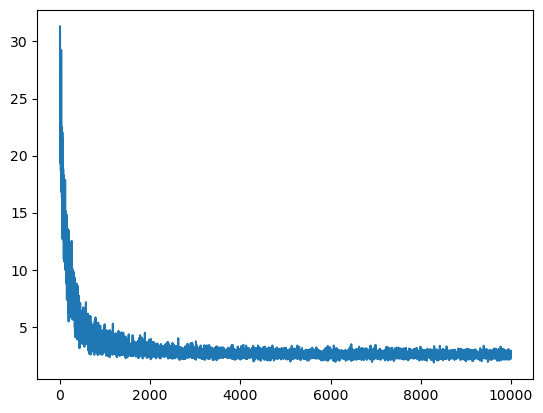

In [35]:
plt.plot(stepi, lossi)

In [36]:
# Evaluating on the training set
emb = C[Xtr]
h = torch.tanh(emb.view((-1,6))@W1 + b1)
logits = h@W2+b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5423, grad_fn=<NllLossBackward0>)

In [37]:
# Evaluating on the validation set
emb = C[Xdev]
h = torch.tanh(emb.view((-1,6))@W1 + b1)
logits = h@W2+b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5307, grad_fn=<NllLossBackward0>)

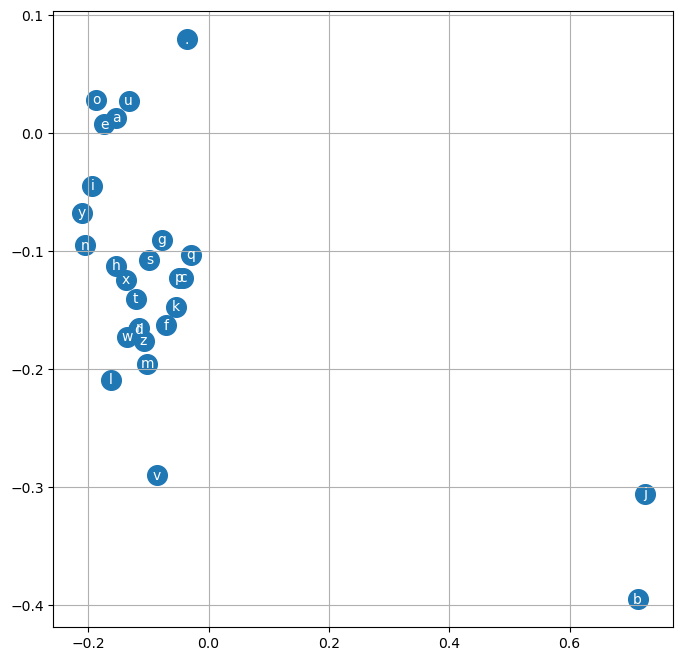

In [38]:
# Lets visualize the embeddings of the characters learnt by the network
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color = 'white')
plt.grid('minor')

To try to make the loss lower, lets try to scale up our embedding layer which could be a bottle neck.

In [62]:
g = torch.Generator().manual_seed(214)
C = torch.randn((27,15), generator = g)
W1 = torch.randn((45, 200), generator = g) # 6 comes since we have 3 chars as input to the neural net and an 
                                          # embedding layer of size 2
b1 = torch.randn((200), generator = g)
W2 = torch.randn((200,27), generator = g)
b2 = torch.randn((27), generator = g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

15032

In [63]:
for p in parameters:
    p.requires_grad = True

In [64]:
stepi = []
lossi = []

In [65]:
for i in range(200000):
    # create mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view((-1,45))@W1 + b1)
    logits = h@W2+b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # do learning rate decay after few iterations and loss plateus as we get to the end of training.
    lr = 0.1 if i <100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.0770156383514404


In [66]:
# Evaluating on the training set
emb = C[Xtr]
h = torch.tanh(emb.view((-1,45))@W1 + b1)
logits = h@W2+b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0909, grad_fn=<NllLossBackward0>)

In [67]:
# Evaluating on the validation set
emb = C[Xdev]
h = torch.tanh(emb.view((-1,45))@W1 + b1)
logits = h@W2+b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1515, grad_fn=<NllLossBackward0>)

In [ ]:
W1.shape

In [46]:
# Sampling from the model
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        # embedding, tanh, softmax
        emb = C[torch.tensor(context)]
        #print(emb.shape)
        h = torch.tanh(emb.view((1,-1))@W1 + b1)
        logits = h@W2+b2
        #print(logits.shape)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0: 
            break
        context = context[1:]+[ix]
    print(''.join(out))

dexze.
momonie.
ila.
kayde.
kolimitta.
nolkwan.
kaida.
samiyah.
javer.
got.
keidlie.
cavo.
keiteda.
kaley.
maside.
enkaviyah.
fols.
milliel.
vorbers.
daspr.
